In [52]:
import datetime as dt
from functools import partial
import itertools as itt
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import re

The `data` dataframe will only be used when initially loading the CSV file

In [53]:
file_path = 'rates.csv'
data = pd.read_csv(file_path, header=None)

The array `fwds` will contain the labels for each of the series of fwd rates, any `nan`s at the end of the CSV file are filtered out of it

In [54]:
fwds = data.iloc[0, :].unique()
fwds = fwds[np.array([isinstance(item, str) for item in fwds])][1:]

The working dataframe will be called `df` and starts as an empty dataframe.  

We iterate through the fwds array getting each `label` and use an index `i` to move across the `data` dataframe.
At each iteration;
1. create a new dataframe _imaginatively_ called `s` which contains each series of dates and forwards
2. we drop any `nan` values from the dates
3. we convert the dates from strings to datetime objects
4. make the date column the index of `s`
5. rename the column of fwds with `label`
6. values of `'00/01/1900'` are artifacts from Excel, and are replaced by `nan`
7. the column containing the forward rate (`s[label]`) is re-cast as a float
8. concatenate to the `df` dataframe

In [55]:
df = pd.DataFrame()
i = 0
for label in fwds:
    s = data.iloc[1:, i:i+2]
    s = s.dropna(subset=[i])
    s[i] = pd.to_datetime(s[i], format=('%d-%b-%y'))
    s = s.set_index(s.columns[0])
    s = s.rename(columns={i+1: label})
    s[label] = s[label].replace('00/01/1900', np.nan)
    s[label] = s[label].astype(float)
    df = pd.concat([df,s],axis=1)
    i += 2

Next we remap the columns with the more common naming convention.  To do this we'll use a first mapping table for the expiry codes, and then use a helper function to build a second mapping table for all the fwds

In [56]:
exp_mapping = {
    'A':'1M',
    'C':'3M',
    'F':'6M',
    'J':'9M',   # not sure about this, is it 1Y?
    'O':'15M',  # not sure about this, is it 18M, 5Y?
    'T':'10Y',
    'Z':'30Y',
}

def remap(fwd):
    exp, tenor, _ = fwd.split('Y')
    exp = exp_mapping[exp] if exp in exp_mapping else exp + 'Y'
    return f'{exp}{int(tenor)}Y'

df = df.rename(columns={f: remap(f) for f in fwds})

Make sure that the dates are ordered.

`ffill` then forward fills any missing values with the value from the previous date
`bfill` fills in any holes at the start, though it might be better to use `dropna` in this case

In [57]:
df = df.sort_index(ascending=True)
df = df.fillna(method='ffill')
df = df.fillna(method='bfill')

Let's use `matplotlib` to plot one of the forward rates
* `xticks` allows us to rotates the tick labels on the `x` axis
* `grid` does what it says on the tin
* `xlabel` and `ylabel` add labels to the respective axes
* the semi-colon at the end hides text output from `plt`

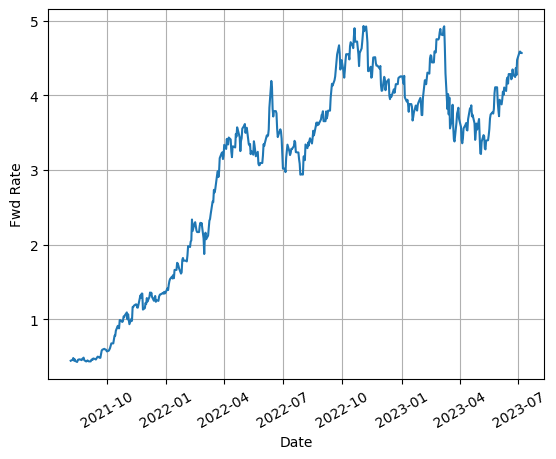

In [58]:
plt.plot(df['1Y1Y'][-500:])
plt.xticks(rotation=30)
plt.grid()
plt.xlabel('Date')
plt.ylabel('Fwd Rate');

Next let's build a couple of helper functions so that we can sort fwds by either their expiry or tenor length.  We won't get too carried away by daycounts, but rather treat years as integers and months as twelfths of a year.

In [59]:
pattern = r'(\d+)([my])(\d+)([my])'
exptenor = re.compile(pattern, flags=re.IGNORECASE)

def period(fwd: str, is_expiry: bool = True):
    mo = re.search(exptenor, fwd)  # match object
    if is_expiry:
        return float(mo[1]) if mo[2].lower() == 'y' else float(mo[1])/12
    return float(mo[3]) if mo[4].lower() == 'y' else float(mo[3])/12

expiry_period = partial(period, is_expiry=True)
tenor_period = partial(period, is_expiry=False)


Now let's get all `n`y tenors ordered from shortest to longest expiry.  Because of the ordering we ensure that pairs of combinations are also ordered.

By iterating across all pairs we can build a dataframe of ll the spreads.

In [64]:
tenor = '5Y'
expiries = sorted(set(col for col in df.columns if col.endswith(tenor)), key=expiry_period)
combinations = itt.combinations(expiries,2)

spreads = pd.DataFrame()
for c1,c2 in itt.combinations(expiries,2):
    spreads[c2 + '-' + c1] = df[c2] - df[c1]

In [65]:
spreads.describe()

,3M5Y-1M5Y,6M5Y-1M5Y,9M5Y-1M5Y,1Y5Y-1M5Y,15M5Y-1M5Y,2Y5Y-1M5Y,3Y5Y-1M5Y,4Y5Y-1M5Y,5Y5Y-1M5Y,7Y5Y-1M5Y,...,5Y5Y-4Y5Y,7Y5Y-4Y5Y,10Y5Y-4Y5Y,30Y5Y-4Y5Y,7Y5Y-5Y5Y,10Y5Y-5Y5Y,30Y5Y-5Y5Y,10Y5Y-7Y5Y,30Y5Y-7Y5Y,30Y5Y-10Y5Y
count,3042.000000,3042.000000,3042.000000,3042.000000,3042.000000,3042.000000,3042.000000,3042.000000,3042.000000,3042.000000,...,3042.00000,3042.000000,3042.000000,3042.000000,3042.000000,3042.000000,3042.000000,3042.000000,3042.000000,3042.000000
mean,0.041918,0.105847,1.133076,0.331000,1.038801,0.400916,0.568047,0.724002,0.857302,1.025010,...,0.13330,0.301008,0.116932,-0.071313,0.167708,-0.016369,-0.204614,-0.184076,-0.372321,-0.188245
std,0.113447,0.197759,0.985509,0.351027,0.959010,0.512160,0.673362,0.792968,0.869050,0.949134,...,0.19662,0.307443,0.416848,0.527131,0.220180,0.353319,0.483864,0.317889,0.472045,0.314599
min,-0.086000,-0.217000,-0.789000,-0.465000,-1.060000,-0.761000,-0.853000,-0.877000,-0.860000,-0.829000,...,-0.19000,-0.142000,-1.140000,-1.456000,-0.392000,-1.208000,-1.486000,-1.098000,-1.578000,-1.000000
25%,0.000000,0.000000,0.420000,0.090000,0.367250,0.000000,0.000000,0.000000,0.174000,0.300000,...,0.00000,0.000000,0.000000,-0.148000,0.000000,-0.062000,-0.338000,-0.249750,-0.603000,-0.304000
50%,0.022000,0.069000,1.000000,0.341000,1.000000,0.279000,0.386000,0.529500,0.774000,1.000000,...,0.07300,0.206500,0.057500,0.000000,0.119000,0.000000,-0.065000,-0.054000,-0.289000,-0.195500
75%,0.069000,0.172000,1.816750,0.505000,1.725750,0.859000,1.096750,1.357750,1.508500,1.680750,...,0.18600,0.499750,0.288000,0.111000,0.220000,0.133000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,3.400000,1.260000,3.167000,1.502000,2.144000,2.629000,2.983000,3.250000,...,1.00000,1.000000,1.000000,1.040000,1.000000,1.000000,1.000000,1.000000,0.860000,0.860000


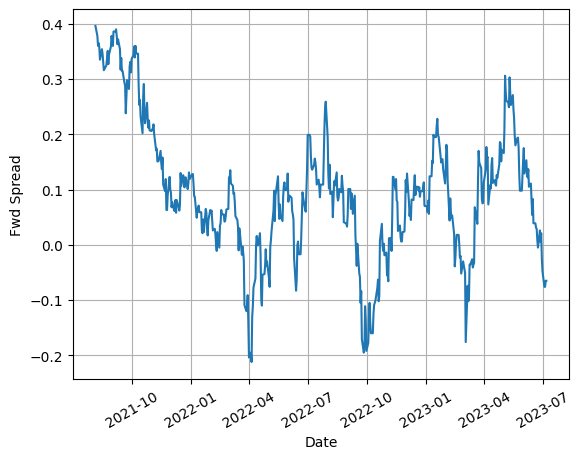

In [77]:
spread = '5Y5Y-2Y5Y'
plt.plot(spreads[spread][-500:])
# plt.title(label=spread)
plt.xticks(rotation=30)
plt.grid()
plt.xlabel('Date')
plt.ylabel('Fwd Spread')
plt.show()